## Run the Self-Organizing Map in redshift bins
___

In [2]:
import os

from astropy.io import fits
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Georgia',
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix',
    'axes.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in'
})

In [2]:
#Load in KiDS data
with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/KiDS_SOM_catalog_15Jul24.fits') as cat:
    KiDS_cat = Table(cat[1].data)

#Load in GAMA data
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_15Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [3]:
#Select the needed data NORMALIZED
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_size_cut = KiDS_cat['half_light_radius'] < 5

input_cat = KiDS_cat[KiDS_mag_cut &\
                     KiDS_size_cut]

labels_cat = GAMA_cat

input_data = Table([
                    2 * (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()) - 1,
                    (input_cat['ug_col'] - input_cat['ug_col'].mean())/input_cat['ug_col'].std(),
                    (input_cat['gr_col'] - input_cat['gr_col'].mean())/input_cat['gr_col'].std(),
                    (input_cat['ri_col'] - input_cat['ri_col'].mean())/input_cat['ri_col'].std(),
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                    ])
input_stds = Table([
                    2 * input_cat['r_mag_err']/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col_err']/input_cat['ug_col'].std(),
                    input_cat['gr_col_err']/input_cat['gr_col'].std(),
                    input_cat['ri_col_err']/input_cat['ri_col'].std(),
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    ])

input_labels = Table([
                      2 * (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()) - 1,
                      (labels_cat['ug_col'] - labels_cat['ug_col'].mean())/labels_cat['ug_col'].std(),
                      (labels_cat['gr_col'] - labels_cat['gr_col'].mean())/labels_cat['gr_col'].std(),
                      (labels_cat['ri_col'] - labels_cat['ri_col'].mean())/labels_cat['ri_col'].std(),
                      np.log10(labels_cat['mstar']),
                      labels_cat['redshift']],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      'log_mstar',
                      'redshift'])

input_label_stds = Table([
                          2 * labels_cat['r_mag_err']/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                          labels_cat['ug_col_err']/labels_cat['ug_col'].std(),
                          labels_cat['gr_col_err']/labels_cat['gr_col'].std(),
                          labels_cat['ri_col_err']/labels_cat['ri_col'].std(),
                          labels_cat['mstar_err']/(labels_cat['mstar'] * np.log(10)),
                          np.abs(labels_cat['ppp'] - 0.5) + 0.01],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          'log_mstar_err',
                          'redshift_err'])

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

Len of input data: 149343
Len of labeling data: 48737


In [4]:
from mpdg_som import SelfOrganizingMap

#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [25, 25] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.64 #used to adjust the learning rate function
kernel_spread = 3.35 #used to adjust the neighborhood function
maximum_steps = 20 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.05 #used to stop the SOM if termination = 'error thresh'

In [5]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [6]:
def run_SOM_in_bin():

    SOM.build_SOM()

    SOM.show_map(cmap = 'jet',
                 save = True, save_path = f'{bin_directory}/SOM_initialized')
    
    SOM.train()

    SOM.show_map(cmap = 'jet',
                 save = True, save_path = f'{bin_directory}/SOM_trained')

    SOM.label_map()

    SOM.show_map(show_labeled = True,
                 cmap = 'jet',
                 save = True, save_path = f'{bin_directory}/SOM_labeled')
    
    SOM.predict(SOM.labeling_data[:, :SOM.data_dim],
                np.sqrt(SOM.label_variances[:, :SOM.data_dim]))
    8
    np.save(f'{bin_directory}/prediction_results',
            SOM.prediction_results, allow_pickle = True)
        
    np.save(f'{bin_directory}/prediction_stds',
            SOM.prediction_sigmas, allow_pickle = True)
    
    np.save(f'{bin_directory}/labeling_data',
            SOM.labeling_data, allow_pickle = True)
    
    np.save(f'{bin_directory}/labeling_stds',
            SOM.label_variances, allow_pickle = True)

Branch out into redshift bins


| SOM. Step 0. Initialization: pca
Step 1 complete. Error: 2.047                                   
Step 2 complete. Error: 1.811                                   
Step 3 complete. Error: 1.675                                   
Step 4 complete. Error: 1.799                                   
Step 5 complete. Error: 1.922                                   
Step 6 complete. Error: 1.658                                   
Step 7 complete. Error: 2.159                                   
Step 8 complete. Error: 1.350                                   
Step 9 complete. Error: 1.307                                   
Step 10 complete. Error: 1.395                                   
Step 11 complete. Error: 1.274                                   
Step 12 complete. Error: 1.298                                   
Step 13 complete. Error: 1.311                                   
Step 14 complete. Error: 1.762                                   
Step 15 complete. Error: 1.448                   

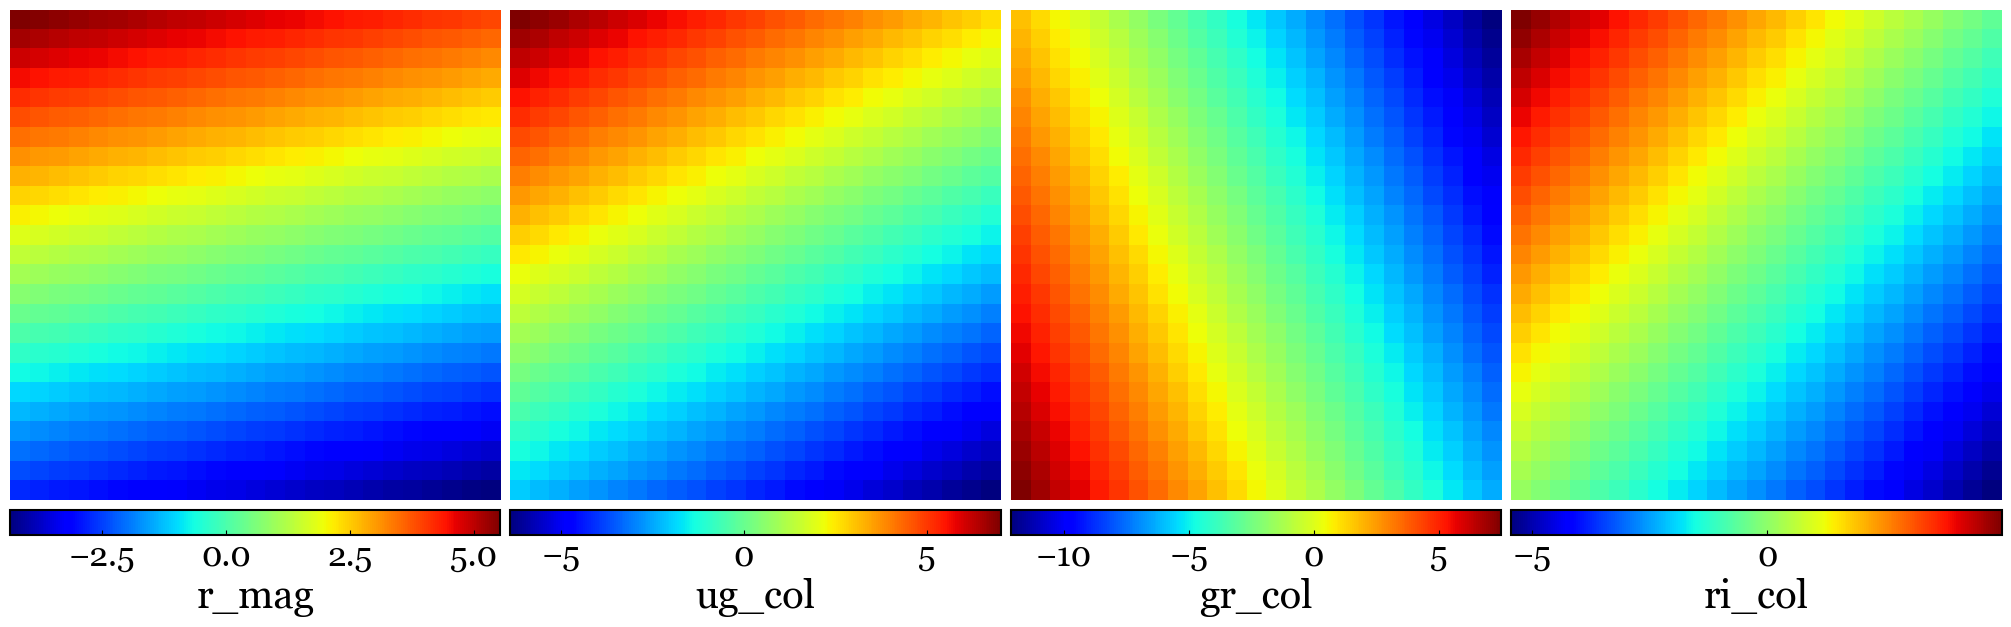

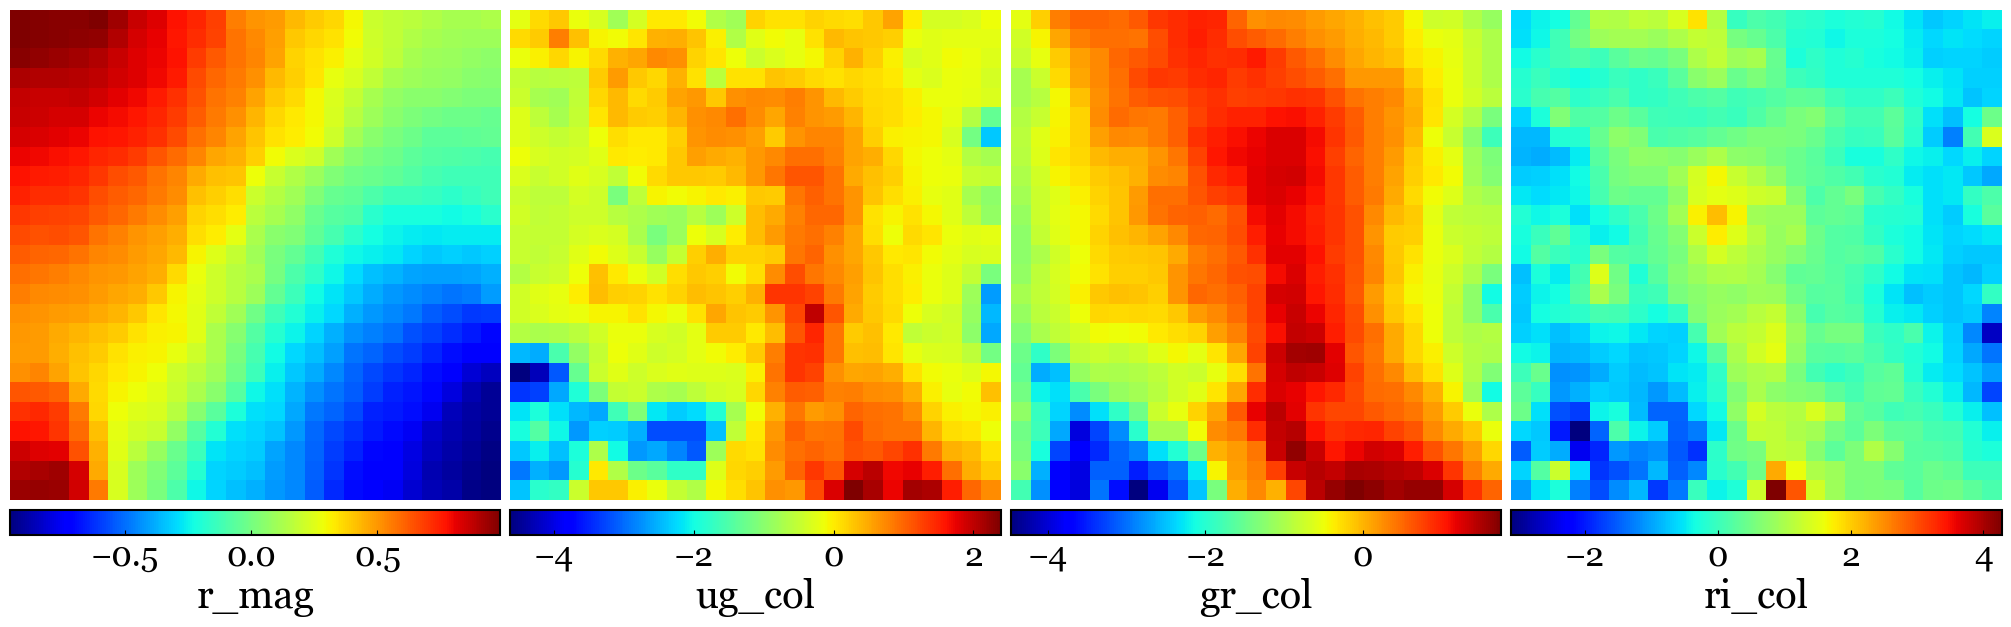

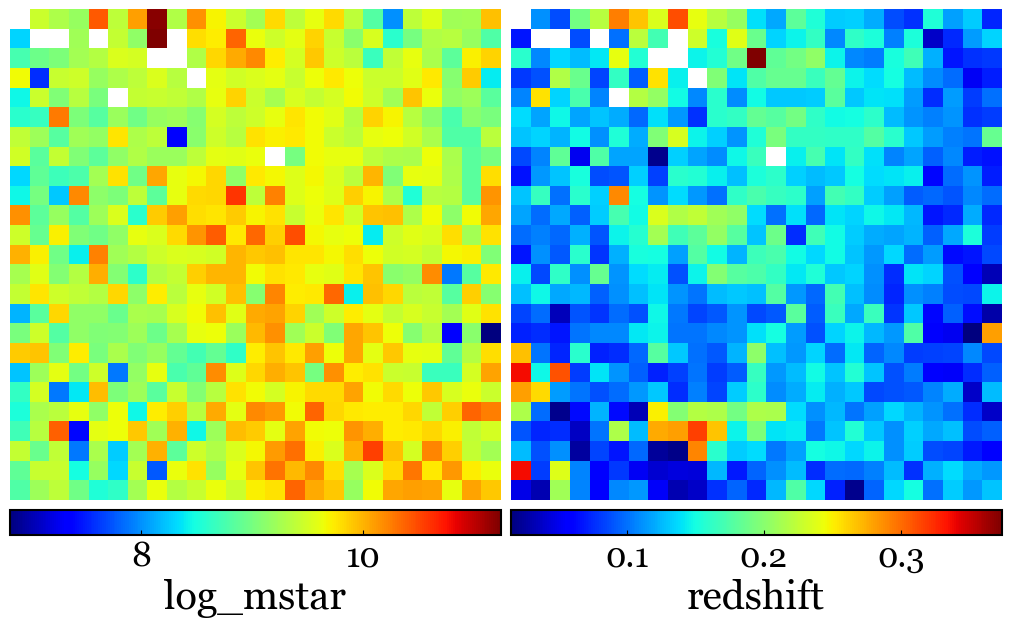

In [13]:
redshift_lo = 0.
redshift_hi = 0.5

input_redshift_bin = (input_cat['redshift'] >  redshift_lo) &\
                     (input_cat['redshift'] <= redshift_hi)

labels_redshift_bin = (labels_cat['redshift'] >  redshift_lo) &\
                      (labels_cat['redshift'] <= redshift_hi)

parent_directory = '/data2/lsajkov/mpdg/saved_soms/16Jul24_z_bins'

bin_directory = f'{parent_directory}/z_bin_{redshift_lo:.1f}_{redshift_hi:.1f}'


if not os.path.exists(parent_directory):
    os.mkdir(parent_directory)
if not os.path.exists(bin_directory):
    os.mkdir(bin_directory)

SOM.load_data(input_data[input_redshift_bin],
              variable_names = ['r_mag', 'ug_col', 'gr_col', 'ri_col'])

SOM.load_standard_deviations(input_stds[input_redshift_bin])
    
SOM.load_labeling_data(input_labels[labels_redshift_bin],
                       parameter_names = ['log_mstar', 'redshift'])
    
SOM.load_labeling_standard_deviations(input_label_stds[labels_redshift_bin])

run_SOM_in_bin()

Make comparison plots

In [178]:
output_vals_file = '/data2/lsajkov/mpdg/saved_soms/16Jul24_z_bins/z_bin_0.0_0.5/prediction_results.npy'
output_stds_file = '/data2/lsajkov/mpdg/saved_soms/16Jul24_z_bins/z_bin_0.0_0.5/prediction_stds.npy'

labels_vals_file = '/data2/lsajkov/mpdg/saved_soms/16Jul24_z_bins/z_bin_0.0_0.5/labeling_data.npy'
labels_stds_file = '/data2/lsajkov/mpdg/saved_soms/16Jul24_z_bins/z_bin_0.0_0.5/labeling_stds.npy'

output_vals = np.load(output_vals_file, allow_pickle = True)
output_stds = np.load(output_stds_file, allow_pickle = True)

labels_vals = np.load(labels_vals_file, allow_pickle = True)
labels_stds = np.load(labels_stds_file, allow_pickle = True)

Mstar_pred     = output_vals[:, 0]
Mstar_pred_std = np.sqrt(output_stds[:, 0])

redshift_pred     = output_vals[:, 1]
redshift_pred_std = np.sqrt(output_stds[:, 1])

Mstar_true     = labels_vals[:, 4]
Mstar_true_std = labels_stds[:, 4]

redshift_true     = labels_vals[:, 5]
redshift_true_std = labels_stds[:, 5]

In [182]:
N_bins = 30

_, bins = np.histogram(Mstar_true, bins = N_bins)

Mstar_true_binned     = np.array([np.mean(Mstar_true,     where = np.digitize(Mstar_true, bins) == i) for i in range(1, N_bins + 2)])
Mstar_true_binned_std = np.array([np.mean(Mstar_true_std, where = np.digitize(Mstar_true, bins) == i) for i in range(1, N_bins + 2)])

Mstar_pred_binned     = np.array([np.mean(Mstar_pred,     where = np.digitize(Mstar_pred, bins) == i) for i in range(1, N_bins + 2)])
Mstar_pred_binned_std = np.array([np.mean(Mstar_pred_std, where = np.digitize(Mstar_pred, bins) == i) for i in range(1, N_bins + 2)])

Mstar_MAD = np.nansum(np.abs(Mstar_true - Mstar_pred))/(np.sum(~np.isnan(Mstar_pred)))

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_2771196/2949867270.py:18: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_2771196/2949867270.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_2771196/2949867270.py:29: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


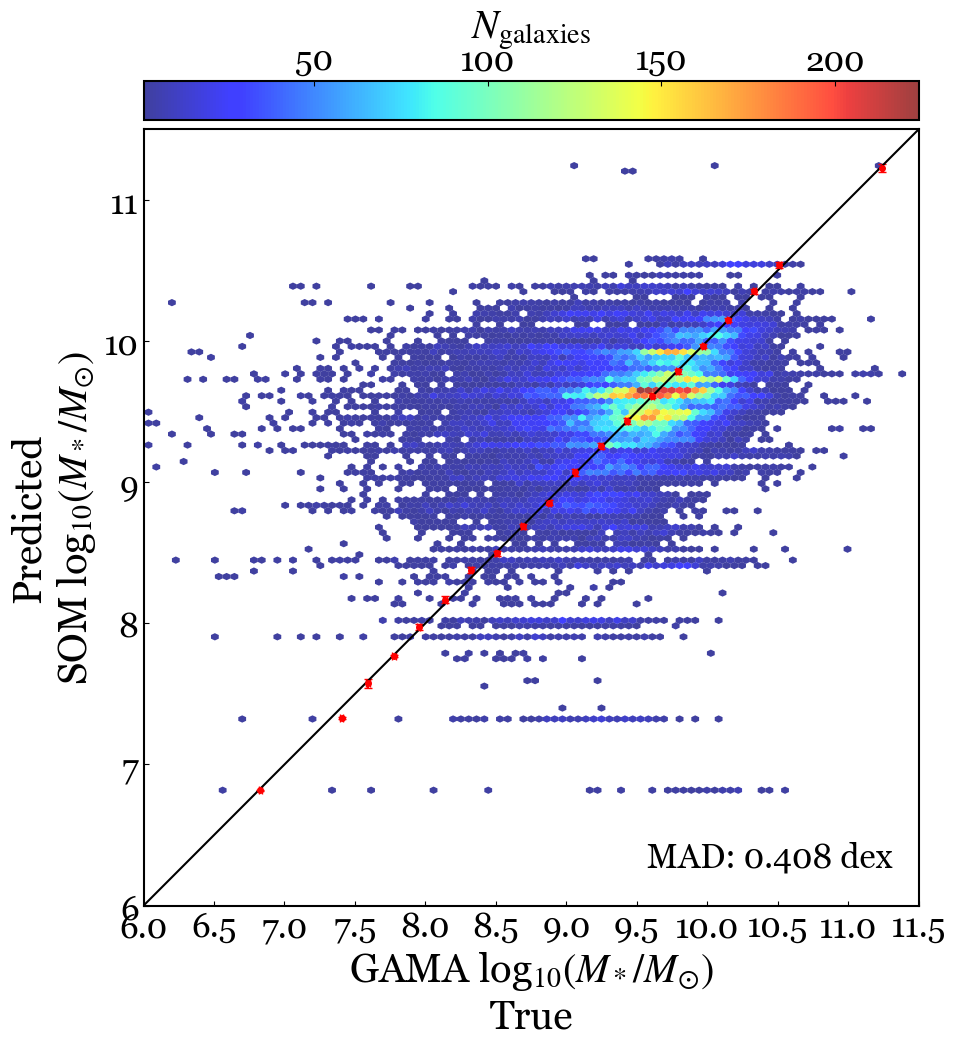

In [183]:
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot()

ax.errorbar(Mstar_true_binned, Mstar_pred_binned,
            xerr = Mstar_true_binned_std, yerr = Mstar_pred_binned_std,
            markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', markersize = 4,
            color = 'none', ecolor = 'red', capsize = 3)
hb = ax.hexbin(Mstar_true, Mstar_pred,
          mincnt = 1, alpha = 0.75, edgecolors = ('none'), cmap = 'jet')

ax.axline([7.5, 7.5], slope = 1, color = 'black')


ax.set_xlim(6, 11.5)
ax.set_ylim(6, 11.5)
ax.set_xticks(np.arange(6, 12, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')


ax.text(0.65, 0.05,
        f'MAD: {Mstar_MAD:.3f} dex',
        transform = ax.transAxes)


fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [184]:
N_bins = 30

in_bin_true, bins = np.histogram(redshift_true, bins = N_bins)
in_bin_pred, bins = np.histogram(redshift_pred, bins = bins)

redshift_true_binned     = np.array([np.mean(redshift_true,     where = np.digitize(redshift_true, bins) == i) for i in range(1, N_bins + 1)])
# redshift_true_binned_std = np.array([np.mean(redshift_true_std, where = np.digitize(redshift_true, bins) == i) for i in range(1, N_bins + 2)])

redshift_pred_binned     = np.array([np.mean(redshift_pred,     where = np.digitize(redshift_pred, bins) == i) for i in range(1, N_bins + 1)])
redshift_pred_binned_std = redshift_pred_binned/np.sqrt(in_bin_pred)
# redshift_pred_binned_std = np.array([np.mean(redshift_pred_std, where = np.digitize(redshift_pred, bins) == i) for i in range(1, N_bins + 2)])

redshift_MAD = np.nansum(np.abs(redshift_pred - redshift_true))/(np.sum(~np.isnan(redshift_pred)))

<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_2771196/314865957.py:28: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


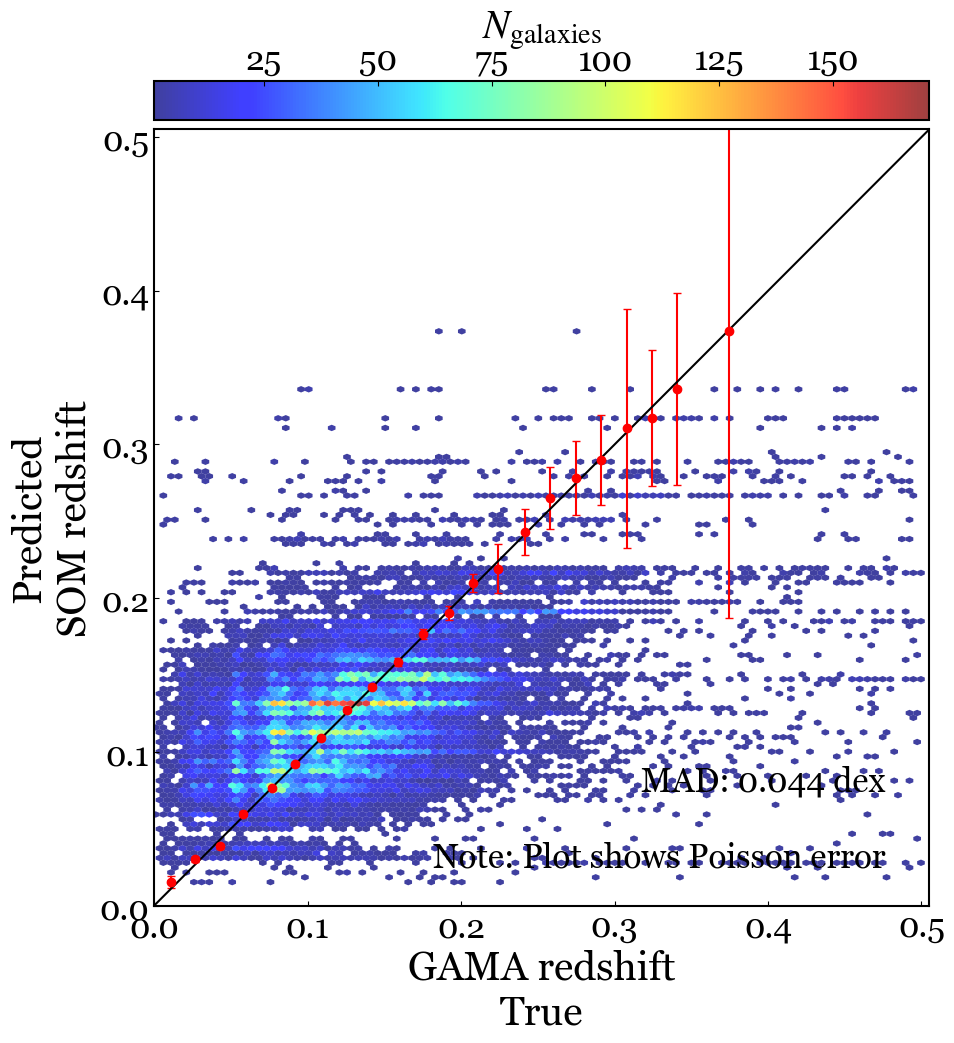

In [185]:
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot()

ax.errorbar(redshift_true_binned, redshift_pred_binned,
            yerr = redshift_pred_binned_std,
            markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', markersize = 6,
            color = 'none', ecolor = 'red', capsize = 3)
hb = ax.hexbin(redshift_true, redshift_pred,
          mincnt = 1, alpha = 0.75, edgecolors = ('none'), cmap = 'jet')

ax.axline([0.05, 0.05], slope = 1, color = 'black')

ax.set_xlim(0.0, 0.505)
ax.set_ylim(0.0, 0.505)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')


ax.text(0.36, 0.05,
        f'MAD: {redshift_MAD:.3f} dex\n\nNote: Plot shows Poisson error',
        ma = 'right',
        transform = ax.transAxes)


fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')